In [1]:
import umap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
cur_dir = os.getcwd()
print(cur_dir)

E:\python\2024.12.01\ContraVis_next


In [3]:
raw_data = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\features.npy")
labels = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\labels.npy")

In [4]:
pattern_type = "random"
intensity = 0.1
noisy_data = np.load(rf"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_{pattern_type}_{intensity}\features.npy")

In [5]:
relation_dict = {k:k for k in range(raw_data.shape[0])}
relation_dicts = [relation_dict]

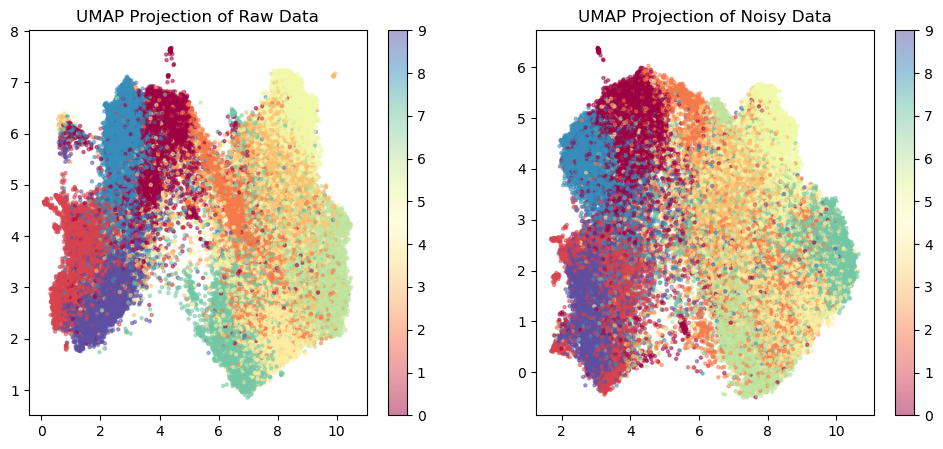

In [78]:
# 使用UMAP降维
umap_reducer = umap.UMAP(n_components=2, n_jobs=-1)

# 对原始数据和噪声数据进行降维
raw_embedded = umap_reducer.fit_transform(raw_data)
noisy_embedded = umap_reducer.fit_transform(noisy_data)

# 绘制UMAP结果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(raw_embedded[:, 0], raw_embedded[:, 1], c=labels, cmap='Spectral', alpha=0.5, s=5)
axes[0].set_title("UMAP Projection of Raw Data")
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(noisy_embedded[:, 0], noisy_embedded[:, 1], c=labels, cmap='Spectral', alpha=0.5, s=5)
axes[1].set_title("UMAP Projection of Noisy Data")
plt.colorbar(scatter2, ax=axes[1])

plt.show()

In [6]:
from scipy.spatial import cKDTree
k = 10  # 取最近的 5 个邻居
radius = 1000  # 搜索的半径
# 构建 KD 树
kd_tree1 = cKDTree(raw_data)
kd_tree2 = cKDTree(noisy_data)
# 查询 K 近邻（包括自身）
distances1, indices1 = kd_tree1.query(raw_data[10000], k=k, distance_upper_bound=radius)
distances2, indices2 = kd_tree2.query(noisy_data[10000], k=k, distance_upper_bound=radius)

# 转换为集合
indices1_set = set(indices1)
indices2_set = set(indices2)
overlapping_indices = indices1_set.intersection(indices2_set)
invalid_index = len(raw_data)  # 确保 raw_data 已定义
overlapping_indices.discard(invalid_index)

# 输出结果
print("KNN重叠的索引:", overlapping_indices)

KNN重叠的索引: {10000, 49326}


In [7]:
import numpy as np
import networkx as nx
import time
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cosine

# 计时函数
def log_time(start_time, step_name):
    elapsed_time = time.time() - start_time
    print(f"{step_name} 耗时: {elapsed_time:.2f} 秒")
    return time.time()
start_time = time.time()
# 计算局部 Laplacian 特征
def compute_laplacian_eigenvalues(graph, node, k=5):
    """ 计算某个节点局部子图的 Laplacian 特征值 """
    neighbors = list(graph.neighbors(node)) + [node]  # 获取邻居和自身
    subgraph = graph.subgraph(neighbors)  # 构造局部子图
    L = nx.laplacian_matrix(subgraph).tocsc().astype(float)  # 计算拉普拉斯矩阵
    n = L.shape[0]  # 子图大小
    k = min(k, n - 1)  # 确保 k 不超过矩阵大小，避免 eigsh 失败

    try:
        if n > 10:  # 适用于较大矩阵
            eigenvalues, _ = eigsh(L, k=k, which='SM', ncv=max(2*k, 10))  # 增加 ncv 提高稳定性
        else:
            eigenvalues = np.linalg.eigh(L.toarray())[0][:k]  # 适用于小型密集矩阵
    except:
        eigenvalues = np.zeros(k)  # 发生错误时返回零特征值
    return eigenvalues

In [8]:
from scipy.sparse.csgraph import connected_components

# 设定 KNN 近邻数
k = 10  

# 计算 KNN 图
knn_graph1 = kneighbors_graph(raw_data, n_neighbors=k, mode='connectivity', include_self=False)
n_components1, labels1 = connected_components(knn_graph1, directed=False)
print("G1-子图数量:", n_components1)
knn_graph2 = kneighbors_graph(noisy_data, n_neighbors=k, mode='connectivity', include_self=False)
n_components2, labels2 = connected_components(knn_graph2, directed=False)
print("G2-子图数量:", n_components2)
start_time = log_time(start_time, "构建 KNN 图")

# 构造 NetworkX 图
G1 = nx.Graph(knn_graph1)
G2 = nx.Graph(knn_graph2)
start_time = log_time(start_time, "构造 NetworkX 图")



# 计算所有点的 Laplacian 特征值
laplacian_features1 = {}
laplacian_features2 = {}

# for i in range(len(raw_data)):
#     laplacian_features1[i] = compute_laplacian_eigenvalues(G1, i)
#     laplacian_features2[i] = compute_laplacian_eigenvalues(G2, i)
#     if i % 100 == 0:
#         print(f"已处理 {i}/{len(raw_data)} 个点...")

# start_time = log_time(start_time, "计算 Laplacian 特征值")
# 
# # 计算余弦相似度
# laplacian_similarities = np.array([
#     1 - cosine(laplacian_features1[i], laplacian_features2[i]) for i in range(len(raw_data))
# ])
# start_time = log_time(start_time, "计算 Laplacian 相似度")
# 
# # 设定阈值，过滤出可以匹配的点
# threshold = 0.8  # 设定相似度阈值
# valid_indices = np.where(laplacian_similarities >= threshold)[0]  # 获取匹配点的索引
# valid_similarities = laplacian_similarities[valid_indices]  # 其对应的相似度
# start_time = log_time(start_time, "筛选匹配点")
# 
# # 输出匹配的点索引和相似度
# print("匹配的点索引:", valid_indices)
# print("相似度列表:", valid_similarities)


G1-子图数量: 1
G2-子图数量: 1
构建 KNN 图 耗时: 28.30 秒
构造 NetworkX 图 耗时: 4.93 秒


[27936, 45281, 16324, 8901, 14667, 24621, 2000, 6676, 49048, 45112, 26910]


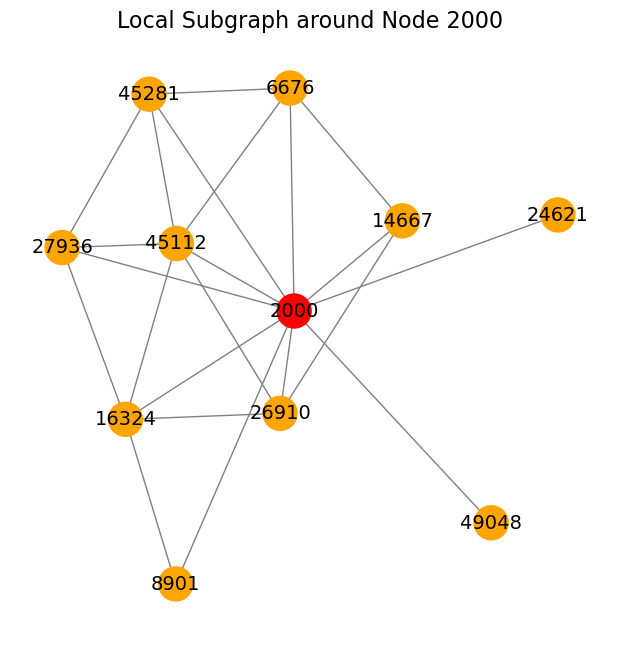

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_subgraph(graph, node):
    """
    可视化某个节点的局部子图，并高亮其邻居节点
    :param graph: NetworkX 图
    :param node: 需要可视化的节点索引
    """
    if node not in graph:
        print(f"节点 {node} 不在图中")
        return

    # 获取邻居和自身
    neighbors = list(graph.neighbors(node))
    sub_nodes = neighbors + [node]
    subgraph = graph.subgraph(sub_nodes)
    print(subgraph.nodes)

    # 计算图布局
    pos = nx.spring_layout(subgraph)

    # 设置颜色列表
    node_colors = []
    for n in subgraph.nodes():
        if n == node:
            node_colors.append("red")  # 被选中节点
        else:
            node_colors.append("orange")  # 邻居节点

    # 绘制图形
    plt.figure(figsize=(6, 6))
    nx.draw(subgraph, pos, with_labels=False, node_color=node_colors,
            edge_color="gray", node_size=600)

    # 绘制标签，字体更大
    nx.draw_networkx_labels(subgraph, pos, font_size=14, font_color="black")

    # 显示图标题
    plt.title(f"Local Subgraph around Node {node}", fontsize=16)
    plt.show()


# 示例：可视化 G1 中的某个节点（替换成你的图）
node_to_visualize = 2000  # 你可以修改这个值
visualize_subgraph(G2, node_to_visualize)


In [72]:
print(compute_laplacian_eigenvalues(G2, node_to_visualize, 5),compute_laplacian_eigenvalues(G1, node_to_visualize, 5))

[-9.10751001e-16  1.00000000e+00  1.00000000e+00  1.33195434e+00
  1.79122568e+00] [2.04839629e-15 1.00000000e+00 1.00000000e+00 1.20220746e+00
 1.46960611e+00]


In [16]:
import dash
from dash import dcc, html, Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
import numpy as np

# 创建 Dash 应用
app = dash.Dash(__name__)

# 颜色方案
colors = px.colors.qualitative.Set1  
point_colors = [colors[label % len(colors)] for label in labels]

# UMAP 视图缩放范围
ZOOM_SCALE = 0.1  # 缩放比例 (10% 视野范围)

# 创建 UMAP 可视化
def create_umap_figure(embedding, graph, selected_index=None):
    highlight_mask = point_colors.copy()
    
    # 选定点及其邻居高亮
    if selected_index is not None:
        neighbors = list(graph.neighbors(selected_index)) + [selected_index]
        highlight_mask = ["gray"] * len(embedding)  # 其他点变灰
        for i in neighbors:
            highlight_mask[i] = point_colors[i]  # 选中点及其邻居恢复颜色

    # 创建 UMAP 散点图
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=embedding[:, 0], y=embedding[:, 1],
        mode="markers",
        marker=dict(color=highlight_mask, opacity=0.7, size=5),
        text=[f"Index: {i}" for i in range(len(embedding))],
        hoverinfo="text",
    ))

    return fig

# 创建 Dash 布局
app.layout = html.Div([
    html.H1("UMAP Visualization: Raw vs Noisy Data"),

    # 文本框输入点索引
    html.Div([
        dcc.Input(
            id="point-input",
            type="number",
            placeholder="Enter point index...",
            debounce=True,  # 失去焦点或按 Enter 触发
            style={"marginBottom": "20px", "padding": "5px", "width": "20%"}
        ),
        html.Button("Submit", id="submit-button", n_clicks=0, style={"marginLeft": "10px"})
    ]),

    # 两张 UMAP 可视化图
    html.Div([
        dcc.Graph(id="umap-plot-raw", style={"width": "48%", "display": "inline-block"}),
        dcc.Graph(id="umap-plot-noisy", style={"width": "48%", "display": "inline-block"}),
    ]),

    # 显示邻居索引（Raw 和 Noisy 空间分别显示）
    html.Div(id="neighbors-info", style={"marginTop": "20px", "fontSize": "18px"})
])

# 交互式回调函数
@app.callback(
    [Output("umap-plot-raw", "figure"),
     Output("umap-plot-noisy", "figure"),
     Output("neighbors-info", "children")],
    [Input("submit-button", "n_clicks")],
    [State("point-input", "value")]
)
def update_graph(n_clicks, selected_index):
    if selected_index is None or selected_index not in valid_indices:
        return create_umap_figure(raw_embedded, G1), create_umap_figure(noisy_embedded, G2), "Enter a valid point index."

    # 获取邻居信息
    neighbors_raw = list(G1.neighbors(selected_index))  # 原始空间邻居
    neighbors_noisy = list(G2.neighbors(selected_index))  # 噪声空间邻居
    
    # 获取该点的相似度（点对 similarity）
    similarity = valid_similarities[valid_indices.tolist().index(selected_index)]

    # 计算缩放范围（UMAP 2D 坐标）
    raw_x, raw_y = raw_embedded[selected_index]
    noisy_x, noisy_y = noisy_embedded[selected_index]

    x_range_raw = [raw_x - ZOOM_SCALE, raw_x + ZOOM_SCALE]
    y_range_raw = [raw_y - ZOOM_SCALE, raw_y + ZOOM_SCALE]

    x_range_noisy = [noisy_x - ZOOM_SCALE, noisy_x + ZOOM_SCALE]
    y_range_noisy = [noisy_y - ZOOM_SCALE, noisy_y + ZOOM_SCALE]

    # 创建 UMAP 图并设置视图范围
    fig_raw = create_umap_figure(raw_embedded, G1, selected_index)
    fig_raw.update_layout(xaxis=dict(range=x_range_raw), yaxis=dict(range=y_range_raw))

    fig_noisy = create_umap_figure(noisy_embedded, G2, selected_index)
    fig_noisy.update_layout(xaxis=dict(range=x_range_noisy), yaxis=dict(range=y_range_noisy))

    # 构建邻居信息文本
    neighbors_text = (
        f"Selected Point: {selected_index}<br><br>"
        f"<b>Neighbors in Raw Space:</b> {neighbors_raw}<br>"
        f"<b>Neighbors in Noisy Space:</b> {neighbors_noisy}<br>"
        f"<b>Similarity:</b> {similarity:.3f}"
    )

    return fig_raw, fig_noisy, neighbors_text

# 运行 Dash 服务器
if __name__ == "__main__":
    app.run_server(debug=True)
